In [2]:
import pandas as pd
import numpy as np
import re
import requests_cache
from bs4 import BeautifulSoup
import warnings
import itertools
import pprint
import urllib
import matplotlib.pyplot as plt
from operator import attrgetter
from slugify import slugify

In [3]:
def to_interval(s):
    """Parse interval string to Interval"""
    if not isinstance(s, str):
        return np.nan
    parts = s.partition('-')
    return pd.Interval(int(parts[0]), int(parts[2]), closed="both")

In [4]:
def extract_data_frame(html, manufacturer, name):
    dfs = pd.read_html(html, match="Weight|weight")
    df = dfs[0]
    
    df = df.transpose()
    
    df.columns = df.iloc[0]
    df = df.assign(manufacturer=manufacturer)
    df = df.assign(name=slugify(name))
    df = df.assign(display_name=name.title())
    df.columns.rename(None, inplace=True)
    
    if 'size' not in df:
        df.index.rename('size', inplace=True)
    df.reset_index(inplace=True)
    df = df.drop(index=0)
    
    df = df.replace(to_replace=r"^Unnamed", value=np.nan, regex=True)
    df = df[df['size'].notna()]
    
    columns = df.columns
    columns = df.columns.str.replace(".*(range|take off|takeoff).*", "weight_range", regex=True, flags=re.I)
    columns = columns.str.replace(".*(cells).*", "cell_count", regex=True, flags=re.I)
    columns = columns.str.replace(".*(area|surface).*", "area", regex=True, flags=re.I)
    columns = columns.str.replace(".*(span).*", "span", regex=True, flags=re.I)
    columns = columns.str.replace(".*(aspect).*", "aspect_ratio", regex=True, flags=re.I)
    columns = columns.str.replace(".*(certification|homologation).*", "certification", regex=True, flags=re.I)
    columns = columns.str.replace(".*(EN|LTF).*", "certification", regex=True)
    columns = columns.str.replace(".*(chord|depth).*", "chord", regex=True, flags=re.I)
    columns = columns.where(~columns.str.contains(".*(?:weight).*", regex=True, flags=re.I) | columns.str.contains(".*(?:bereich|range).*", regex=True, flags=re.I), "weight")
    
    # Account for
    # * cm in chord (and other fields)
    # * missing values in colspan
    # * certification per weight range: https://www.advance.swiss/en/products/paragliders/pi-3
    
    def map_projected(column):
        nonlocal columns
        nonlocal df
        for index in columns.get_indexer_for([column]):           
            if re.search("project", df.columns[index], flags=re.I):
                columns.array[index] = f"projected_{column}"
            else:
                columns.array[index] = f"flat_{column}"
                
    map_projected("area")
    map_projected("span")
    map_projected("aspect_ratio")
    
    weight_range_indices = columns.get_indexer_for(["weight_range"])
    if len(weight_range_indices) > 1:
        for index in weight_range_indices:
            if re.search("recommended|standard|ideal", df.columns[index], flags=re.I):
                columns.array[index] = "recommended_weight_range"
            elif re.search("extended", df.columns[index], flags=re.I):
                columns.array[index] = "extended_weight_range"
            elif re.search("certified", df.columns[index], flags=re.I):
                columns.array[index] = "certified_weight_range"
            else:
                warnings.warn(f"Weight range type couldn't be inferred: '{df.columns[index]}''")
    else:
        for index in weight_range_indices:
            columns.array[index] = "certified_weight_range"
    
    if not "certified_weight_range" in columns.array:
        raise Exception("Couldn't identify certified_weight_range column")
            
    for index in columns.get_indexer_for(["chord"]):
        if re.search("min", df.columns[index], flags=re.I):
            columns.array[index] = "min_chord"
    
    df.columns = columns
    df = df.loc[:,~df.columns.duplicated()]
    
    string_columns = ["manufacturer", "name", "size", "certification", "display_name", "cell_count"]
    range_columns = ["certified_weight_range", "recommended_weight_range", "extended_weight_range"]
    numeric_columns = ["projected_span", "projected_area", "projected_aspect_ratio", "flat_span", "flat_area", "flat_aspect_ratio", "chord", "weight"]
    all_columns = string_columns + range_columns + numeric_columns
    
    df["certification"] = df["certification"].str.extract("([ABCD]{1,3})")
    
    all_columns = list(set(all_columns) & set(df.columns.array))
    df = df.reindex(columns=all_columns)
    df.set_index(["manufacturer", "name", "size"], inplace=True)    
    
    range_columns = list(set(range_columns) & set(df.columns.array))
    df[range_columns] = df[range_columns].applymap(to_interval)
    
    numeric_columns = list(set(numeric_columns) & set(df.columns.array))
    df[numeric_columns] = df[numeric_columns].replace('[^0-9\,\.]', '', regex=True)
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors="coerce")
    
    return df

In [5]:
session = requests_cache.CachedSession('main_cache')
def process(manufacturer, url, name=None):
    page = session.get(url)
    
    if name is None:
        soup = BeautifulSoup(page.text, 'html.parser')
        name = (soup.find("h1") or soup.find("h2")).get_text().strip()
    
    sanitized_text = page.text.replace(",", ".")
    return extract_data_frame(sanitized_text, manufacturer, name)

In [6]:
def extract_links(base_url, url_pattern, extract_name=True):
    page = session.get(base_url)
    soup = BeautifulSoup(page.text, 'html.parser')
    links = []
    for tag in soup.find_all(href=re.compile(url_pattern)):
        text = tag.get_text().strip()
        if len(text) > 0:
            href = tag.get('href')
            url = urllib.parse.urljoin(base_url, href, allow_fragments=True)
            links.append((url, tag.get_text().strip()))

    links.sort()
    grouped_links = itertools.groupby(links, lambda x: x[0])
    filtered_links = []
    for group in grouped_links:
        if extract_name:
            filtered_links.append(min(group[1], key=lambda x: len(x[1])))
        else:
            filtered_links.append((group[0], None))
    return filtered_links

In [7]:
sites = [
    ("nova", "https://www.nova.eu/en", "gliders/.+"),
    ("gin", "https://www.gingliders.com/en/paragliders", "paragliders/.+"),
    ("phi", "https://phi-air.com", ".*project/.+"),
    ("bgd", "https://www.flybgd.com/en/paragliders/paragliders-beginner-intermediate-expert-2-0-0.html", ".*paragliders/.*--paraglider.*", False),
    ("advance", "https://www.advance.swiss/en", ".*products\/paragliders.*"),
#     ("U-Turn", "http://www.u-turn.de/web/english/home", "paragliders/.+", False)
    ("skywalk", "https://skywalk.info", "project/.+")
]

In [8]:
dataframes = []
for site in sites:
    for glider in extract_links(*site[1:]):
        try:
            dataframes.append(process(site[0], *glider))
        except Exception as e:
            warnings.warn(f"Failed to process site {glider[0]}: {e}")
df = pd.concat(dataframes)

/var/folders/sz/bv3p8syd3bj552dbxwpr5tbm0000gn/T/ipykernel_22815/2574275530.py:7: UserWarning: Failed to process site https://www.nova.eu/en/gliders/bantam/: invalid literal for int() with base 10: ''
  warnings.warn(f"Failed to process site {glider[0]}: {e}")
/var/folders/sz/bv3p8syd3bj552dbxwpr5tbm0000gn/T/ipykernel_22815/2574275530.py:7: UserWarning: Failed to process site https://www.nova.eu/en/gliders/doubleskin/: invalid literal for int() with base 10: '75/ 75-90'
  warnings.warn(f"Failed to process site {glider[0]}: {e}")
/var/folders/sz/bv3p8syd3bj552dbxwpr5tbm0000gn/T/ipykernel_22815/3117462041.py:60: UserWarning: Weight range type couldn't be inferred: 'ext. weight range motor''
  warnings.warn(f"Weight range type couldn't be inferred: '{df.columns[index]}''")
/var/folders/sz/bv3p8syd3bj552dbxwpr5tbm0000gn/T/ipykernel_22815/3117462041.py:60: UserWarning: Weight range type couldn't be inferred: 'ext. weight range motor''
  warnings.warn(f"Weight range type couldn't be inferred

/var/folders/sz/bv3p8syd3bj552dbxwpr5tbm0000gn/T/ipykernel_22815/2574275530.py:7: UserWarning: Failed to process site https://www.advance.swiss/en/products/paragliders: No tables found
  warnings.warn(f"Failed to process site {glider[0]}: {e}")
/var/folders/sz/bv3p8syd3bj552dbxwpr5tbm0000gn/T/ipykernel_22815/3117462041.py:60: UserWarning: Weight range type couldn't be inferred: 'Increased takeoff weight''
  warnings.warn(f"Weight range type couldn't be inferred: '{df.columns[index]}''")
/var/folders/sz/bv3p8syd3bj552dbxwpr5tbm0000gn/T/ipykernel_22815/3117462041.py:60: UserWarning: Weight range type couldn't be inferred: 'Certification increased takeoff weight''
  warnings.warn(f"Weight range type couldn't be inferred: '{df.columns[index]}''")
/var/folders/sz/bv3p8syd3bj552dbxwpr5tbm0000gn/T/ipykernel_22815/2574275530.py:7: UserWarning: Failed to process site https://www.advance.swiss/en/products/paragliders/alpha-7: Couldn't identify certified_weight_range column
  warnings.warn(f"Fail

In [60]:
with open('template.html', 'r') as template:
    with open('index.html', 'w') as fp:
        table = df.to_html(border = 0, classes='table table-hover')
        html = template.read().format(table)
        fp.write(html)

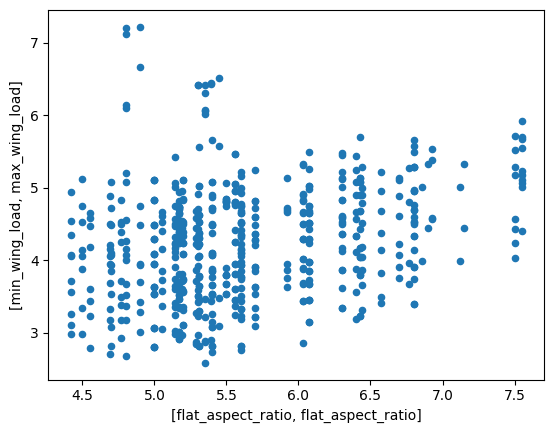

In [61]:
df2 = df.dropna(subset=['projected_area']).copy()

# def avb(row):
#     print(row['certified_weight_range'])
#     print(row['projected_area'])
#     print(row['certified_weight_range'] / row['projected_area'])
#     return row['certified_weight_range'] / row['projected_area']

# df2['wing_load'] = df2.apply(lambda row: avb(row), axis=1)

# df2.loc[df2["certified_weight_range"].map(attrgetter('left')) >= df2["certified_weight_range"].map(attrgetter('right'))]
# df2["certified_weight_range"][:,0]
df2["min_wing_load"] = df2["certified_weight_range"].map(attrgetter('left')) / df2["projected_area"]
df2["max_wing_load"] = df2["certified_weight_range"].map(attrgetter('right')) / df2["projected_area"]

# df2
df2.plot(x=["flat_aspect_ratio", "flat_aspect_ratio"], y=["min_wing_load", "max_wing_load"], kind="scatter")
plt.show()

# plt.scatter(df2["wing_load"], df2["projected_aspect_ratio"])

In [1]:
df2.plot(x=["certification", "certification"], y=["min_wing_load", "max_wing_load"], kind="scatter")
plt.show()

NameError: name 'df2' is not defined